# Retrieve and analyze match odds data for the 2023-2024 EPL season to determine the most profitable betting strategy purely based on odds. Compare profit and loss for the following scenarios: home win, draw, away win, favorite, underdog, and random selections.


In [36]:


# Import the requests module for making HTTP requests
import requests

# this is the data returned from curlconverter after the copy as cURL (bash) selection from the the website

# Define headers to be used in the HTTP request
headers = {
    'accept': 'application/json, text/plain, */*',  # Specify accepted response types
    'accept-language': 'en-GB,en;q=0.9,en-US;q=0.8',  # Set accepted languages
    'content-type': 'application/json',  # Specify content type of the request
    # 'cookie': '...',  # Commented out for privacy; include if needed for authentication
    'priority': 'u=1, i',  # Set request priority
    'referer': 'https://www.oddsportal.com/football/england/premier-league-2023-2024/results/',  # Referer URL
    'sec-ch-ua': '"Not/A)Brand";v="8", "Chromium";v="126", "Microsoft Edge";v="126"',  # User agent hints
    'sec-ch-ua-mobile': '?0',  # Specify if the client is a mobile device
    'sec-ch-ua-platform': '"Windows"',  # Specify the platform
    'sec-fetch-dest': 'empty',  # Fetch destination
    'sec-fetch-mode': 'cors',  # Fetch mode
    'sec-fetch-site': 'same-origin',  # Fetch site
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126.0.0.0 Safari/537.36 Edg/126.0.0.0',  # User agent
    'x-requested-with': 'XMLHttpRequest',  # Specify the request type
    'x-xsrf-token': 'eyJpdiI6InlJNWQvZzMxdDc4QnZYaDYxdXNGZUE9PSIsInZhbHVlIjoiYzAyMFkzcy9sdzFYQW5ScXFEZE1uYkJNV1dvSmNqWFhyK2ZJRmVRU0RqbEhCUCttT1F0dG13RExNSTh3RE9UOFE4anYvZWhXNjBQbWRnak14czh5RzNKOUdIWWNHUExHWG5obE4rWTBHalRaTTlCYkJxN1lPL3g3VnFOc0R1ZWwiLCJtYWMiOiIxNDdmYmNhZjU1ZjFlNTk5ZWNiNDVmYTljZDc1ZTA3YzAwNzBhYmE3MjFlZGQyNDQ1ZDhjNDU4NTA1NjgwOTNmIiwidGFnIjoiIn0=',  # XSRF token for security
}

# Define query parameters for the HTTP request
params = {
    '_': '1720030517197',  # Timestamp or unique identifier for the request
}

# Make a GET request to the specified URL with headers and parameters
response = requests.get(
    'https://www.oddsportal.com/ajax-sport-country-tournament-archive_/1/jDTEm9zs/X337756164X16384X67584X0X0X0X0X0X8388608X0X0X0X0X1X0X0X0X0X0X0X33554432X0X0X131072X0X0X134217728/0/0/',
    params=params,
    headers=headers,
)

# Extract the requested URL from curl converter so we can format it for the def fetch_page_data 
requested_url = response.url
print(requested_url)

# Output the status code of the response
response.status_code



https://www.oddsportal.com/ajax-sport-country-tournament-archive_/1/jDTEm9zs/X337756164X16384X67584X0X0X0X0X0X8388608X0X0X0X0X1X0X0X0X0X0X0X33554432X0X0X131072X0X0X134217728/0/0/?_=1720030517197


200

In [37]:
# Create a base URL by ensuring the scheme and path are correctly formatted
# Find the position of "/?"
pos = requested_url.find("/?")

# Replace anything after "/?" with "/page/"
if pos != -1:
    base_url = requested_url[:pos] + "/page/"
else:
    base_url = requested_url + "/page/"

print(base_url)


https://www.oddsportal.com/ajax-sport-country-tournament-archive_/1/jDTEm9zs/X337756164X16384X67584X0X0X0X0X0X8388608X0X0X0X0X1X0X0X0X0X0X0X33554432X0X0X131072X0X0X134217728/0/0/page/


In [38]:
import requests
import json
import pandas as pd
from datetime import datetime

# Function to fetch and process data from a single page
def fetch_page_data(page_number):
    url = f'{base_url}{page_number}/'  # Construct the URL with the current page number
    response = requests.get(url, headers=headers)  # Make the request to the URL
    
    if response.status_code == 200:
        return response.json()  # Return JSON response if the request is successful
    else:
        print(f"Failed to fetch data for page {page_number}")
        return None  # Return None if the request fails

# Function to filter data and include date
def filter_data(page_data):
    filtered_data = []
    for match in page_data['d']['rows']:
        # Convert Unix timestamp to readable date and time
        match_datetime = datetime.utcfromtimestamp(match["date-start-timestamp"])
        match_date = match_datetime.strftime('%Y-%m-%d')
        match_time = match_datetime.strftime('%H:%M:%S')

        # Split the result into home and away scores
        if match["result"]:
            home_score, away_score = match["result"].split(':')
            home_score = int(home_score)
            away_score = int(away_score)
        else:
            home_score, away_score = None, None

        # Determine match result
        if home_score is not None and away_score is not None:
            if home_score > away_score:
                match_result = 'h'  # Home win
            elif home_score < away_score:
                match_result = 'a'  # Away win
            else:
                match_result = 'x'  # Draw
        else:
            match_result = None  # Result not available

        # Create a dictionary for the filtered match data
        filtered_match = {
            "home-name": match["home-name"],
            "away-name": match["away-name"],
            "home-score": home_score,
            "away-score": away_score,
            "match_result": match_result,
            "tournament-name": match["tournament-name"],
            "date": match_date,
            "time": match_time,
            "home_odds": None,
            "draw_odds": None,
            "away_odds": None
        }
        
        # Extract and label odds assuming the order is home, draw, away
        if len(match['odds']) >= 3:
            filtered_match['home_odds'] = match['odds'][0]['avgOdds']
            filtered_match['draw_odds'] = match['odds'][1]['avgOdds']
            filtered_match['away_odds'] = match['odds'][2]['avgOdds']
        else:
            print(f"Warning: Match {match['home-name']} vs {match['away-name']} does not have enough odds entries.")
        
        filtered_data.append(filtered_match)
    
    return filtered_data

# Extract the tournament name from the first page
page_data = fetch_page_data(1)
if page_data:
    tournament_name = page_data['d']['rows'][0]['tournament-name']
    # Clean the tournament name to create a valid filename
    tournament_name_cleaned = tournament_name.replace(' ', '_').replace('/', '-')

# Loop through pages and collect data
all_filtered_data = []

for page_number in range(1, 20): # put 20 as max saves checking site for exact number 
    page_data = fetch_page_data(page_number)
    if page_data:
        filtered_data = filter_data(page_data)
        all_filtered_data.extend(filtered_data)

# If the actual number of pages is less than the range, no errors will occur, 
# the loop will end normally after attempting to fetch all pages in the range.

# Convert the filtered data to a DataFrame
df = pd.DataFrame(all_filtered_data)

# Save the DataFrame to a CSV file with the tournament name
df.to_csv(f'{tournament_name_cleaned}_odds_v1.csv', index=False)

# Print DataFrame to verify
print(df.head())

print("Data fetching, processing, and conversion to DataFrame complete.")


   home-name       away-name  home-score  away-score match_result  \
0    Arsenal         Everton           2           1            h   
1  Brentford       Newcastle           2           4            a   
2   Brighton  Manchester Utd           0           2            a   
3    Burnley      Nottingham           1           2            a   
4    Chelsea     Bournemouth           2           1            h   

            tournament-name        date      time  home_odds  draw_odds  \
0  Premier League 2023/2024  2024-05-19  15:00:00       1.21       7.18   
1  Premier League 2023/2024  2024-05-19  15:00:00       2.91       3.92   
2  Premier League 2023/2024  2024-05-19  15:00:00       2.56       3.97   
3  Premier League 2023/2024  2024-05-19  15:00:00       2.87       3.67   
4  Premier League 2023/2024  2024-05-19  15:00:00       1.39       5.55   

   away_odds  
0      12.23  
1       2.20  
2       2.41  
3       2.32  
4       6.82  
Data fetching, processing, and conversion to

In [5]:
# load the df in from a csv file
# Define the filename dynamically using the cleaned tournament name
filename = f'{tournament_name_cleaned}_odds_v1.csv'

# Load the DataFrame from the dynamically created filename
odds_data = pd.read_csv(filename)

# Print a message indicating the data was loaded successfully
print(f"Data loaded from {filename} successfully.")

# Print the first few rows to verify the data
odds_data.head()

Data loaded from Premier_League_2023-2024_odds_v1.csv successfully.


,home-name,away-name,home-score,away-score,match_result,tournament-name,date,time,home_odds,draw_odds,away_odds
0,Arsenal,Everton,2,1,h,Premier League 2023/2024,2024-05-19,15:00:00,1.21,7.18,12.23
1,Brentford,Newcastle,2,4,a,Premier League 2023/2024,2024-05-19,15:00:00,2.91,3.92,2.20
2,Brighton,Manchester Utd,0,2,a,Premier League 2023/2024,2024-05-19,15:00:00,2.56,3.97,2.41
3,Burnley,Nottingham,1,2,a,Premier League 2023/2024,2024-05-19,15:00:00,2.87,3.67,2.32
4,Chelsea,Bournemouth,2,1,h,Premier League 2023/2024,2024-05-19,15:00:00,1.39,5.55,6.82


In [40]:
# Tidying up the DataFrame
# 1. Rename columns, 2. Reorder columns, 3. Sort by date in ascending order, 4. Reset index

# Step 1: Rename Columns
new_column_names = {
    'home-name': 'home',
    'away-name': 'away',
    'home-score': 'home_goals',
    'away-score': 'away_goals',
    'match_result': 'result',
    'tournament-name': 'tournament',
    'date': 'date',
    'time': 'time',
    'home_odds': 'home_odds',
    'draw_odds': 'draw_odds',
    'away_odds': 'away_odds'
}
# Rename the columns in the DataFrame
odds_data.rename(columns=new_column_names, inplace=True)

# Step 2: Reorder Columns
desired_order = ['tournament', 'date', 'time', 'home', 'away', 'home_goals', 'away_goals', 'result', 'home_odds', 'draw_odds', 'away_odds']
# Reorder the DataFrame columns
odds_data = odds_data[desired_order]

# Step 3: Sort by Date
# Convert 'date' column to datetime format
odds_data['date'] = pd.to_datetime(odds_data['date'])
# Sort the DataFrame by 'date' column in ascending order
odds_data.sort_values(by='date', ascending=True, inplace=True)

# Step 4: Reset Index
# Reset the DataFrame index and drop the old index
odds_data.reset_index(drop=True, inplace=True)

# Display the DataFrame to verify changes
odds_data.head()



,tournament,date,time,home,away,home_goals,away_goals,result,home_odds,draw_odds,away_odds
0,Premier League 2023/2024,2023-08-11,19:00:00,Burnley,Manchester City,0,3,a,9.22,5.27,1.32
1,Premier League 2023/2024,2023-08-12,16:30:00,Newcastle,Aston Villa,5,1,h,1.63,4.02,5.12
2,Premier League 2023/2024,2023-08-12,14:00:00,Bournemouth,West Ham,1,1,x,2.63,3.46,2.57
3,Premier League 2023/2024,2023-08-12,11:30:00,Arsenal,Nottingham,2,1,h,1.18,7.10,14.65
4,Premier League 2023/2024,2023-08-12,14:00:00,Everton,Fulham,0,1,a,2.29,3.24,3.21


In [41]:
# Sanity check - Verify the number of games played per team
# Playoff teams will play more if applicable for said league 

# Count games played by each team
home_games_count = odds_data['home'].value_counts()  # Count home games for each team
away_games_count = odds_data['away'].value_counts()  # Count away games for each team

# Sum home and away games to get the total number of games played by each team
total_games_count = home_games_count.add(away_games_count, fill_value=0).astype(int)

# Create a DataFrame for better readability
total_games_count_df = total_games_count.reset_index()
total_games_count_df.columns = ['team', 'total_games_played']

# Reset the index to start at 1
total_games_count_df.index = total_games_count_df.index + 1

# Print the DataFrame to check games played by each team
print(total_games_count_df)




               team  total_games_played
1           Arsenal                  38
2       Aston Villa                  38
3       Bournemouth                  38
4         Brentford                  38
5          Brighton                  38
6           Burnley                  38
7           Chelsea                  38
8    Crystal Palace                  38
9           Everton                  38
10           Fulham                  38
11        Liverpool                  38
12            Luton                  38
13  Manchester City                  38
14   Manchester Utd                  38
15        Newcastle                  38
16       Nottingham                  38
17    Sheffield Utd                  38
18        Tottenham                  38
19         West Ham                  38
20           Wolves                  38


In [42]:
odds_data.head()

,tournament,date,time,home,away,home_goals,away_goals,result,home_odds,draw_odds,away_odds
0,Premier League 2023/2024,2023-08-11,19:00:00,Burnley,Manchester City,0,3,a,9.22,5.27,1.32
1,Premier League 2023/2024,2023-08-12,16:30:00,Newcastle,Aston Villa,5,1,h,1.63,4.02,5.12
2,Premier League 2023/2024,2023-08-12,14:00:00,Bournemouth,West Ham,1,1,x,2.63,3.46,2.57
3,Premier League 2023/2024,2023-08-12,11:30:00,Arsenal,Nottingham,2,1,h,1.18,7.10,14.65
4,Premier League 2023/2024,2023-08-12,14:00:00,Everton,Fulham,0,1,a,2.29,3.24,3.21


In [44]:
# Add a 'result_1x2' column based on 'result' column as my preference of viewing results 
# The new column will use '1' for home win ('h'), '2' for away win ('a'), and 'x' for draw ('x')
odds_data['result_1x2'] = odds_data['result'].apply(lambda x: '1' if x == 'h' else ('2' if x == 'a' else 'x'))

# Print the DataFrame to verify the changes
odds_data.head()



,tournament,date,time,home,away,home_goals,away_goals,result,home_odds,draw_odds,away_odds,result_1x2
0,Premier League 2023/2024,2023-08-11,19:00:00,Burnley,Manchester City,0,3,a,9.22,5.27,1.32,2
1,Premier League 2023/2024,2023-08-12,16:30:00,Newcastle,Aston Villa,5,1,h,1.63,4.02,5.12,1
2,Premier League 2023/2024,2023-08-12,14:00:00,Bournemouth,West Ham,1,1,x,2.63,3.46,2.57,x
3,Premier League 2023/2024,2023-08-12,11:30:00,Arsenal,Nottingham,2,1,h,1.18,7.10,14.65,1
4,Premier League 2023/2024,2023-08-12,14:00:00,Everton,Fulham,0,1,a,2.29,3.24,3.21,2


In [45]:
import numpy as np

# Function to determine the favourite and favourite odds
def determine_favourite(row):
    # Create a dictionary with odds for home win ('1'), draw ('x'), and away win ('2')
    odds = {
        '1': row['home_odds'],
        'x': row['draw_odds'],
        '2': row['away_odds']
    }
    # Find the outcome with the minimum odds (the favourite)
    favourite = min(odds, key=odds.get)
    favourite_odds = odds[favourite]
    # Return the favourite and its odds
    return pd.Series([favourite, favourite_odds])

# Apply the function to each row to create the new columns
odds_data[['favourite', 'favourite_odds']] = odds_data.apply(determine_favourite, axis=1)

# Create the 'fav_status' column based on whether the result matches the favourite
odds_data['fav_status'] = np.where(odds_data['result_1x2'] == odds_data['favourite'], 'won', 'lost')

# Print the DataFrame to verify the changes
odds_data.head()


,tournament,date,time,home,away,home_goals,away_goals,result,home_odds,draw_odds,away_odds,result_1x2,favourite,favourite_odds,fav_status
0,Premier League 2023/2024,2023-08-11,19:00:00,Burnley,Manchester City,0,3,a,9.22,5.27,1.32,2,2,1.32,won
1,Premier League 2023/2024,2023-08-12,16:30:00,Newcastle,Aston Villa,5,1,h,1.63,4.02,5.12,1,1,1.63,won
2,Premier League 2023/2024,2023-08-12,14:00:00,Bournemouth,West Ham,1,1,x,2.63,3.46,2.57,x,2,2.57,lost
3,Premier League 2023/2024,2023-08-12,11:30:00,Arsenal,Nottingham,2,1,h,1.18,7.10,14.65,1,1,1.18,won
4,Premier League 2023/2024,2023-08-12,14:00:00,Everton,Fulham,0,1,a,2.29,3.24,3.21,2,1,2.29,lost


In [47]:
import numpy as np

# Function to determine the underdog and underdog odds
def determine_underdog(row):
    # Create a dictionary with odds for home win ('1'), draw ('x'), and away win ('2')
    odds = {
        '1': row['home_odds'],
        'x': row['draw_odds'],
        '2': row['away_odds']
    }
    # Find the outcome with the maximum odds (the underdog)
    underdog = max(odds, key=odds.get)
    underdog_odds = odds[underdog]
    # Return the underdog and its odds
    return pd.Series([underdog, underdog_odds])

# Apply the function to each row to create the new columns for underdog and underdog odds
odds_data[['underdog', 'underdog_odds']] = odds_data.apply(determine_underdog, axis=1)

# Create the 'underdog_status' column based on whether the result matches the underdog
odds_data['underdog_status'] = np.where(odds_data['result_1x2'] == odds_data['underdog'], 'won', 'lost')

# Print the DataFrame to verify the changes
odds_data.head()



,tournament,date,time,home,away,home_goals,away_goals,result,home_odds,draw_odds,away_odds,result_1x2,favourite,favourite_odds,fav_status,underdog,underdog_odds,underdog_status
0,Premier League 2023/2024,2023-08-11,19:00:00,Burnley,Manchester City,0,3,a,9.22,5.27,1.32,2,2,1.32,won,1,9.22,lost
1,Premier League 2023/2024,2023-08-12,16:30:00,Newcastle,Aston Villa,5,1,h,1.63,4.02,5.12,1,1,1.63,won,2,5.12,lost
2,Premier League 2023/2024,2023-08-12,14:00:00,Bournemouth,West Ham,1,1,x,2.63,3.46,2.57,x,2,2.57,lost,x,3.46,won
3,Premier League 2023/2024,2023-08-12,11:30:00,Arsenal,Nottingham,2,1,h,1.18,7.10,14.65,1,1,1.18,won,2,14.65,lost
4,Premier League 2023/2024,2023-08-12,14:00:00,Everton,Fulham,0,1,a,2.29,3.24,3.21,2,1,2.29,lost,x,3.24,lost


In [48]:
# Add new columns for potential profit or loss on a £1 bet, initially empty
odds_data['Home P/L £1 stake'] = None  # Potential profit or loss for a £1 bet on the home team
odds_data['Draw P/L £1 stake'] = None  # Potential profit or loss for a £1 bet on a draw
odds_data['Away P/L £1 stake'] = None  # Potential profit or loss for a £1 bet on the away team
odds_data['Favourite P/L £1 stake'] = None  # Potential profit or loss for a £1 bet on the favourite
odds_data['Underdog P/L £1 stake'] = None  # Potential profit or loss for a £1 bet on the underdog

# Display the DataFrame to verify the changes
odds_data.head()



,tournament,date,time,home,away,home_goals,away_goals,result,home_odds,draw_odds,away_odds,result_1x2,favourite,favourite_odds,fav_status,underdog,underdog_odds,underdog_status,Home P/L £1 stake,Draw P/L £1 stake,Away P/L £1 stake,Favourite P/L £1 stake,Underdog P/L £1 stake
0,Premier League 2023/2024,2023-08-11,19:00:00,Burnley,Manchester City,0,3,a,9.22,5.27,1.32,2,2,1.32,won,1,9.22,lost,None,None,None,None,None
1,Premier League 2023/2024,2023-08-12,16:30:00,Newcastle,Aston Villa,5,1,h,1.63,4.02,5.12,1,1,1.63,won,2,5.12,lost,None,None,None,None,None
2,Premier League 2023/2024,2023-08-12,14:00:00,Bournemouth,West Ham,1,1,x,2.63,3.46,2.57,x,2,2.57,lost,x,3.46,won,None,None,None,None,None
3,Premier League 2023/2024,2023-08-12,11:30:00,Arsenal,Nottingham,2,1,h,1.18,7.10,14.65,1,1,1.18,won,2,14.65,lost,None,None,None,None,None
4,Premier League 2023/2024,2023-08-12,14:00:00,Everton,Fulham,0,1,a,2.29,3.24,3.21,2,1,2.29,lost,x,3.24,lost,None,None,None,None,None


In [49]:
# Ensure that the 'result_1x2' column is treated as a string
# We keep 'result_1x2' as a string type because it contains non-numeric characters ('X' for a draw).
# This allows us to compare the values correctly without performing any calculations on them.
odds_data['result_1x2'] = odds_data['result_1x2'].astype(str)

# Calculate profit/loss per £1 stake for home win
odds_data['Home P/L £1 stake'] = odds_data.apply(
    lambda row: (row['home_odds'] - 1) if row['result_1x2'] == '1' else -1, axis=1
)

# Calculate profit/loss per £1 stake for draw
odds_data['Draw P/L £1 stake'] = odds_data.apply(
    lambda row: (row['draw_odds'] - 1) if row['result_1x2'] == 'x' else -1, axis=1
)

# Calculate profit/loss per £1 stake for away win
odds_data['Away P/L £1 stake'] = odds_data.apply(
    lambda row: (row['away_odds'] - 1) if row['result_1x2'] == '2' else -1, axis=1
)

# Calculate profit/loss per £1 stake for favourite based on whether the favourite team wins
odds_data['Favourite P/L £1 stake'] = odds_data.apply(
    lambda row: (row['favourite_odds'] - 1) if row['result_1x2'] == row['favourite'] else -1, axis=1
)

# Calculate profit/loss per £1 stake for underdog based on whether the underdog team wins
odds_data['Underdog P/L £1 stake'] = odds_data.apply(
    lambda row: (row['underdog_odds'] - 1) if row['result_1x2'] == row['underdog'] else -1, axis=1
)

# Display the DataFrame to verify the changes
odds_data.head()

# returns 


,tournament,date,time,home,away,home_goals,away_goals,result,home_odds,draw_odds,away_odds,result_1x2,favourite,favourite_odds,fav_status,underdog,underdog_odds,underdog_status,Home P/L £1 stake,Draw P/L £1 stake,Away P/L £1 stake,Favourite P/L £1 stake,Underdog P/L £1 stake
0,Premier League 2023/2024,2023-08-11,19:00:00,Burnley,Manchester City,0,3,a,9.22,5.27,1.32,2,2,1.32,won,1,9.22,lost,-1.00,-1.00,0.32,0.32,-1.00
1,Premier League 2023/2024,2023-08-12,16:30:00,Newcastle,Aston Villa,5,1,h,1.63,4.02,5.12,1,1,1.63,won,2,5.12,lost,0.63,-1.00,-1.00,0.63,-1.00
2,Premier League 2023/2024,2023-08-12,14:00:00,Bournemouth,West Ham,1,1,x,2.63,3.46,2.57,x,2,2.57,lost,x,3.46,won,-1.00,2.46,-1.00,-1.00,2.46
3,Premier League 2023/2024,2023-08-12,11:30:00,Arsenal,Nottingham,2,1,h,1.18,7.10,14.65,1,1,1.18,won,2,14.65,lost,0.18,-1.00,-1.00,0.18,-1.00
4,Premier League 2023/2024,2023-08-12,14:00:00,Everton,Fulham,0,1,a,2.29,3.24,3.21,2,1,2.29,lost,x,3.24,lost,-1.00,-1.00,2.21,-1.00,-1.00


In [50]:
# Save the DataFrame to a CSV file with the tournament name and _v2 suffix

odds_data.to_csv(f'{tournament_name_cleaned}_v2.csv', index=False)


In [51]:
import pandas as pd

# Function to format values with £ symbol and negative sign before £
def format_currency(value):
    if value < 0:
        return f"-£{abs(value)}"
    else:
        return f"£{value}"

# Assuming champ_odds_2324 is your DataFrame
# Calculate totals for each specified column
total_home_return = round(odds_data['Home P/L £1 stake'].sum(), 2)  # Total profit/loss from home bets
total_draw_return = round(odds_data['Draw P/L £1 stake'].sum(), 2)  # Total profit/loss from draw bets
total_away_return = round(odds_data['Away P/L £1 stake'].sum(), 2)  # Total profit/loss from away bets
total_favourite_return = round(odds_data['Favourite P/L £1 stake'].sum(), 2)  # Total profit/loss from favourite bets
total_underdog_return = round(odds_data['Underdog P/L £1 stake'].sum(), 2)  # Total profit/loss from underdog bets

# Calculate total number of games
total_games = odds_data.shape[0]  # Total number of games

# Calculate total cost of stakes
total_cost_of_stakes = f"£{total_games}"  # Total cost of placing £1 bet on each game

# Print the totals with £ symbol and negative sign before £
print("Total P/L for a £1 stake on a Home result for every game for the season:", format_currency(total_home_return))
print("Total P/L for a £1 stake on a Draw result for every game for the season:", format_currency(total_draw_return))
print("Total P/L for a £1 stake on a Away result for every game for the season:", format_currency(total_away_return))
print("Total P/L for a £1 stake on a Favourite result for every game for the season:", format_currency(total_favourite_return))
print("Total P/L for a £1 stake on a Underdog result for every game for the season:", format_currency(total_underdog_return))
#print("Total cost of stakes:", total_cost_of_stakes)



Total P/L for a £1 stake on a Home result for every game for the season: -£27.51
Total P/L for a £1 stake on a Draw result for every game for the season: -£47.14
Total P/L for a £1 stake on a Away result for every game for the season: -£49.55
Total P/L for a £1 stake on a Favourite result for every game for the season: £8.23
Total P/L for a £1 stake on a Underdog result for every game for the season: -£77.04


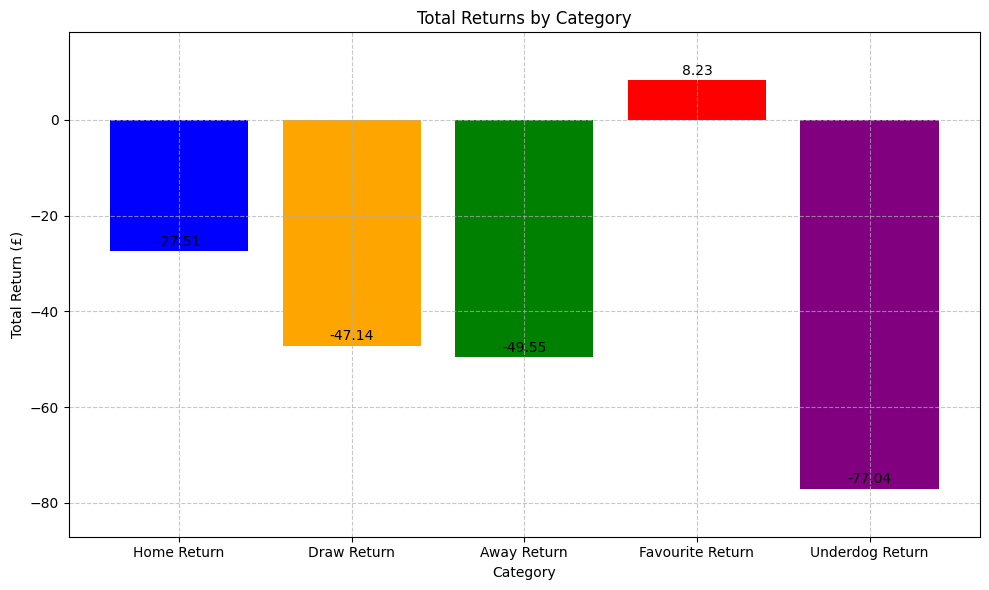

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame for plotting
totals_df = pd.DataFrame({
    'Category': ['Home Return', 'Draw Return', 'Away Return', 'Favourite Return', 'Underdog Return'],
    'Total': [total_home_return, total_draw_return, total_away_return, total_favourite_return, total_underdog_return]
})

# Plotting the bar chart
plt.figure(figsize=(10, 6))  # Set the size of the figure
plt.bar(totals_df['Category'], totals_df['Total'], color=['blue', 'orange', 'green', 'red', 'purple'])  # Create a bar chart
plt.xlabel('Category')  # Label for the x-axis
plt.ylabel('Total Return (£)')  # Label for the y-axis
plt.title('Total Returns by Category')  # Title of the chart
plt.ylim(min(totals_df['Total']) - 10, max(totals_df['Total']) + 10)  # Adjust y-axis for better visualization
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines with custom styling

# Annotate the bars with the total values
for index, value in enumerate(totals_df['Total']):
    plt.text(index, value + 0.5, str(value), ha='center', va='bottom')  # Add text annotation above each bar

plt.tight_layout()  # Adjust layout for better fit
plt.show()  # Display the plot


In [18]:
# returns in similar fashion to 1,x,2 returns but with random choices
# for match selection so will need some more columns and will make 5 lots
# of random selection on all matches and compare returns 

In [54]:
# Adding the new empty columns for random selections and their corresponding odds and returns
for i in range(1, 6):
    odds_data[f'random_selection_{i}'] = ''  # Column for random selection (1, x, or 2)
    odds_data[f'random_selection_{i} odds'] = ''  # Column for the odds corresponding to the random selection
    odds_data[f'random_selection_{i} P/L £1 stake'] = ''  # Column for the profit/loss for a £1 stake based on the random selection

# Display the DataFrame to verify the changes
odds_data.head()



,tournament,date,time,home,away,home_goals,away_goals,result,home_odds,draw_odds,away_odds,result_1x2,favourite,favourite_odds,fav_status,underdog,underdog_odds,underdog_status,Home P/L £1 stake,Draw P/L £1 stake,Away P/L £1 stake,Favourite P/L £1 stake,Underdog P/L £1 stake,random_selection_1,random_selection_1 odds,random_selection_1 P/L £1 stake,random_selection_2,random_selection_2 odds,random_selection_2 P/L £1 stake,random_selection_3,random_selection_3 odds,random_selection_3 P/L £1 stake,random_selection_4,random_selection_4 odds,random_selection_4 P/L £1 stake,random_selection_5,random_selection_5 odds,random_selection_5 P/L £1 stake
0,Premier League 2023/2024,2023-08-11,19:00:00,Burnley,Manchester City,0,3,a,9.22,5.27,1.32,2,2,1.32,won,1,9.22,lost,-1.00,-1.00,0.32,0.32,-1.00,,,,,,,,,,,,,,,
1,Premier League 2023/2024,2023-08-12,16:30:00,Newcastle,Aston Villa,5,1,h,1.63,4.02,5.12,1,1,1.63,won,2,5.12,lost,0.63,-1.00,-1.00,0.63,-1.00,,,,,,,,,,,,,,,
2,Premier League 2023/2024,2023-08-12,14:00:00,Bournemouth,West Ham,1,1,x,2.63,3.46,2.57,x,2,2.57,lost,x,3.46,won,-1.00,2.46,-1.00,-1.00,2.46,,,,,,,,,,,,,,,
3,Premier League 2023/2024,2023-08-12,11:30:00,Arsenal,Nottingham,2,1,h,1.18,7.10,14.65,1,1,1.18,won,2,14.65,lost,0.18,-1.00,-1.00,0.18,-1.00,,,,,,,,,,,,,,,
4,Premier League 2023/2024,2023-08-12,14:00:00,Everton,Fulham,0,1,a,2.29,3.24,3.21,2,1,2.29,lost,x,3.24,lost,-1.00,-1.00,2.21,-1.00,-1.00,,,,,,,,,,,,,,,


In [56]:
import pandas as pd
import numpy as np

# Populating random_select columns with a random choice from 1, x, 2
choices = ['1', 'x', '2']
for i in range(1, 6):
    # Assign a random choice from '1', 'x', '2' for each match
    odds_data[f'random_selection_{i}'] = np.random.choice(choices, len(odds_data))

# Display all columns in the DataFrame to verify the changes
pd.set_option('display.max_columns', None)

# Display the DataFrame to verify the changes
odds_data.head()



,tournament,date,time,home,away,home_goals,away_goals,result,home_odds,draw_odds,away_odds,result_1x2,favourite,favourite_odds,fav_status,underdog,underdog_odds,underdog_status,Home P/L £1 stake,Draw P/L £1 stake,Away P/L £1 stake,Favourite P/L £1 stake,Underdog P/L £1 stake,random_selection_1,random_selection_1 odds,random_selection_1 P/L £1 stake,random_selection_2,random_selection_2 odds,random_selection_2 P/L £1 stake,random_selection_3,random_selection_3 odds,random_selection_3 P/L £1 stake,random_selection_4,random_selection_4 odds,random_selection_4 P/L £1 stake,random_selection_5,random_selection_5 odds,random_selection_5 P/L £1 stake
0,Premier League 2023/2024,2023-08-11,19:00:00,Burnley,Manchester City,0,3,a,9.22,5.27,1.32,2,2,1.32,won,1,9.22,lost,-1.00,-1.00,0.32,0.32,-1.00,2,1.32,,x,1.32,,2,1.32,,1,1.32,,1,1.32,
1,Premier League 2023/2024,2023-08-12,16:30:00,Newcastle,Aston Villa,5,1,h,1.63,4.02,5.12,1,1,1.63,won,2,5.12,lost,0.63,-1.00,-1.00,0.63,-1.00,1,5.12,,2,5.12,,x,5.12,,1,5.12,,2,5.12,
2,Premier League 2023/2024,2023-08-12,14:00:00,Bournemouth,West Ham,1,1,x,2.63,3.46,2.57,x,2,2.57,lost,x,3.46,won,-1.00,2.46,-1.00,-1.00,2.46,x,2.57,,1,2.57,,x,2.57,,x,2.57,,1,2.57,
3,Premier League 2023/2024,2023-08-12,11:30:00,Arsenal,Nottingham,2,1,h,1.18,7.10,14.65,1,1,1.18,won,2,14.65,lost,0.18,-1.00,-1.00,0.18,-1.00,2,14.65,,1,14.65,,1,14.65,,x,14.65,,2,14.65,
4,Premier League 2023/2024,2023-08-12,14:00:00,Everton,Fulham,0,1,a,2.29,3.24,3.21,2,1,2.29,lost,x,3.24,lost,-1.00,-1.00,2.21,-1.00,-1.00,1,3.21,,2,3.21,,2,3.21,,1,3.21,,x,3.21,


In [57]:

# Populating random_odds columns based on random_select values
for i in range(1, 6):
    odds_data[f'random_selection_{i} odds'] = odds_data.apply(
        lambda row: row['home_odds'] if row[f'random_selection_{i}'] == '1' else 
                    row['draw_odds'] if row[f'random_selection_{i}'] == 'x' else 
                    row['away_odds'], axis=1)

# Display the DataFrame
odds_data.head()


,tournament,date,time,home,away,home_goals,away_goals,result,home_odds,draw_odds,away_odds,result_1x2,favourite,favourite_odds,fav_status,underdog,underdog_odds,underdog_status,Home P/L £1 stake,Draw P/L £1 stake,Away P/L £1 stake,Favourite P/L £1 stake,Underdog P/L £1 stake,random_selection_1,random_selection_1 odds,random_selection_1 P/L £1 stake,random_selection_2,random_selection_2 odds,random_selection_2 P/L £1 stake,random_selection_3,random_selection_3 odds,random_selection_3 P/L £1 stake,random_selection_4,random_selection_4 odds,random_selection_4 P/L £1 stake,random_selection_5,random_selection_5 odds,random_selection_5 P/L £1 stake
0,Premier League 2023/2024,2023-08-11,19:00:00,Burnley,Manchester City,0,3,a,9.22,5.27,1.32,2,2,1.32,won,1,9.22,lost,-1.00,-1.00,0.32,0.32,-1.00,2,1.32,,x,5.27,,2,1.32,,1,9.22,,1,9.22,
1,Premier League 2023/2024,2023-08-12,16:30:00,Newcastle,Aston Villa,5,1,h,1.63,4.02,5.12,1,1,1.63,won,2,5.12,lost,0.63,-1.00,-1.00,0.63,-1.00,1,1.63,,2,5.12,,x,4.02,,1,1.63,,2,5.12,
2,Premier League 2023/2024,2023-08-12,14:00:00,Bournemouth,West Ham,1,1,x,2.63,3.46,2.57,x,2,2.57,lost,x,3.46,won,-1.00,2.46,-1.00,-1.00,2.46,x,3.46,,1,2.63,,x,3.46,,x,3.46,,1,2.63,
3,Premier League 2023/2024,2023-08-12,11:30:00,Arsenal,Nottingham,2,1,h,1.18,7.10,14.65,1,1,1.18,won,2,14.65,lost,0.18,-1.00,-1.00,0.18,-1.00,2,14.65,,1,1.18,,1,1.18,,x,7.10,,2,14.65,
4,Premier League 2023/2024,2023-08-12,14:00:00,Everton,Fulham,0,1,a,2.29,3.24,3.21,2,1,2.29,lost,x,3.24,lost,-1.00,-1.00,2.21,-1.00,-1.00,1,2.29,,2,3.21,,2,3.21,,1,2.29,,x,3.24,


In [58]:
# Calculating random_returns based on whether result_1x2 matches random_select
for i in range(1, 6):
    # Calculate the return for a £1 stake based on random selection
    odds_data[f'random_selection_{i} P/L £1 stake'] = odds_data.apply(
        lambda row: row[f'random_selection_{i} odds'] - 1 if row['result_1x2'] == row[f'random_selection_{i}'] else -1, axis=1
    )


In [23]:
odds_data.head()

,tournament,date,time,home,away,home_goals,away_goals,result,home_odds,draw_odds,away_odds,result_1x2,favourite,favourite_odds,fav_status,underdog,underdog_odds,underdog_status,Home P/L £1 stake,Draw P/L £1 stake,Away P/L £1 stake,Favourite P/L £1 stake,Underdog P/L £1 stake,random_selection_1,random_selection_1 odds,random_selection_1 P/L £1 stake,random_selection_2,random_selection_2 odds,random_selection_2 P/L £1 stake,random_selection_3,random_selection_3 odds,random_selection_3 P/L £1 stake,random_selection_4,random_selection_4 odds,random_selection_4 P/L £1 stake,random_selection_5,random_selection_5 odds,random_selection_5 P/L £1 stake
0,Premier League 2023/2024,2023-08-11,19:00:00,Burnley,Manchester City,0,3,a,9.22,5.27,1.32,2,2,1.32,won,1,9.22,lost,-1.00,-1.00,0.32,0.32,-1.00,x,5.27,-1.00,2,1.32,0.32,1,9.22,-1.00,x,5.27,-1.00,1,9.22,-1.00
1,Premier League 2023/2024,2023-08-12,16:30:00,Newcastle,Aston Villa,5,1,h,1.63,4.02,5.12,1,1,1.63,won,2,5.12,lost,0.63,-1.00,-1.00,0.63,-1.00,x,4.02,-1.00,1,1.63,0.63,2,5.12,-1.00,2,5.12,-1.00,1,1.63,0.63
2,Premier League 2023/2024,2023-08-12,14:00:00,Bournemouth,West Ham,1,1,x,2.63,3.46,2.57,x,2,2.57,lost,x,3.46,won,-1.00,2.46,-1.00,-1.00,2.46,x,3.46,2.46,2,2.57,-1.00,x,3.46,2.46,x,3.46,2.46,1,2.63,-1.00
3,Premier League 2023/2024,2023-08-12,11:30:00,Arsenal,Nottingham,2,1,h,1.18,7.10,14.65,1,1,1.18,won,2,14.65,lost,0.18,-1.00,-1.00,0.18,-1.00,2,14.65,-1.00,x,7.10,-1.00,x,7.10,-1.00,x,7.10,-1.00,1,1.18,0.18
4,Premier League 2023/2024,2023-08-12,14:00:00,Everton,Fulham,0,1,a,2.29,3.24,3.21,2,1,2.29,lost,x,3.24,lost,-1.00,-1.00,2.21,-1.00,-1.00,x,3.24,-1.00,2,3.21,2.21,1,2.29,-1.00,2,3.21,2.21,2,3.21,2.21


In [59]:
import pandas as pd

# Function to format values with £ symbol and negative sign before £
def format_currency(value):
    if value < 0:
        return f"-£{abs(value)}"
    else:
        return f"£{value}"

# Assuming champ_odds_2324 is your DataFrame
# Calculate totals for each specified column
total_home_return = round(odds_data['Home P/L £1 stake'].sum(), 2)  # Total profit/loss from home bets
total_draw_return = round(odds_data['Draw P/L £1 stake'].sum(), 2)  # Total profit/loss from draw bets
total_away_return = round(odds_data['Away P/L £1 stake'].sum(), 2)  # Total profit/loss from away bets
total_favourite_return = round(odds_data['Favourite P/L £1 stake'].sum(), 2)  # Total profit/loss from favourite bets
total_underdog_return = round(odds_data['Underdog P/L £1 stake'].sum(), 2)  # Total profit/loss from underdog bets
total_random_return_1 = round(odds_data['random_selection_1 P/L £1 stake'].sum(), 2)
total_random_return_2 = round(odds_data['random_selection_2 P/L £1 stake'].sum(), 2)
total_random_return_3 = round(odds_data['random_selection_3 P/L £1 stake'].sum(), 2)
total_random_return_4 = round(odds_data['random_selection_4 P/L £1 stake'].sum(), 2)
total_random_return_5 = round(odds_data['random_selection_5 P/L £1 stake'].sum(), 2)


# Calculate total number of games
total_games = odds_data.shape[0]  # Total number of games

# Calculate total cost of stakes
total_cost_of_stakes = f"£{total_games}"  # Total cost of placing £1 bet on each game

# Print the totals with £ symbol and negative sign before £
print("Total P/L for a £1 stake on a Home result for every game for the season:", format_currency(total_home_return))
print("Total P/L for a £1 stake on a Draw result for every game for the season:", format_currency(total_draw_return))
print("Total P/L for a £1 stake on a Away result for every game for the season:", format_currency(total_away_return))
print("Total P/L for a £1 stake on a Favourite result for every game for the season:", format_currency(total_favourite_return))
print("Total P/L for a £1 stake on a Underdog result for every game for the season:", format_currency(total_underdog_return))

print("Total P/L for a £1 stake on a Randomly_selected(1) result for every game for the season:", format_currency(total_random_return_1))
print("Total P/L for a £1 stake on a Randomly_selected(2) result for every game for the season:", format_currency(total_random_return_2))
print("Total P/L for a £1 stake on a Randomly_selected(3) result for every game for the season:", format_currency(total_random_return_3))
print("Total P/L for a £1 stake on a Randomly_selected(4) result for every game for the season:", format_currency(total_random_return_4))
print("Total P/L for a £1 stake on a Randomly_selected(5) result for every game for the season:", format_currency(total_random_return_5))
print("Total cost of stakes:", total_cost_of_stakes)
#print("Total cost of stakes:", total_cost_of_stakes)

Total P/L for a £1 stake on a Home result for every game for the season: -£27.51
Total P/L for a £1 stake on a Draw result for every game for the season: -£47.14
Total P/L for a £1 stake on a Away result for every game for the season: -£49.55
Total P/L for a £1 stake on a Favourite result for every game for the season: £8.23
Total P/L for a £1 stake on a Underdog result for every game for the season: -£77.04
Total P/L for a £1 stake on a Randomly_selected(1) result for every game for the season: -£88.04
Total P/L for a £1 stake on a Randomly_selected(2) result for every game for the season: -£5.14
Total P/L for a £1 stake on a Randomly_selected(3) result for every game for the season: -£43.18
Total P/L for a £1 stake on a Randomly_selected(4) result for every game for the season: -£31.03
Total P/L for a £1 stake on a Randomly_selected(5) result for every game for the season: -£66.79
Total cost of stakes: £380


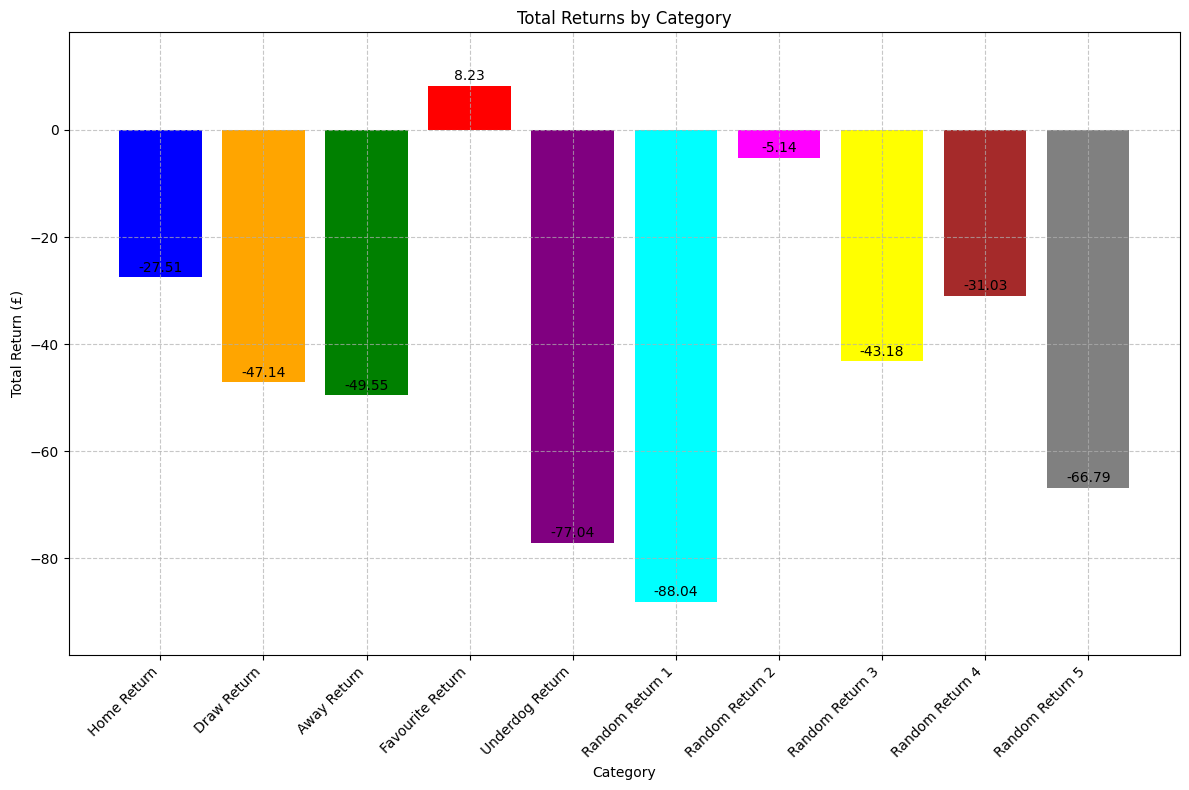

In [60]:
# Create a DataFrame for plotting
totals_df = pd.DataFrame({
    'Category': ['Home Return', 'Draw Return', 'Away Return', 'Favourite Return', 'Underdog Return',
                 'Random Return 1', 'Random Return 2', 'Random Return 3', 'Random Return 4', 'Random Return 5'],
    'Total': [total_home_return, total_draw_return, total_away_return, total_favourite_return, total_underdog_return,
              total_random_return_1, total_random_return_2, total_random_return_3, total_random_return_4, total_random_return_5]
})

# Plotting the bar chart
plt.figure(figsize=(12, 8))
plt.bar(totals_df['Category'], totals_df['Total'], color=['blue', 'orange', 'green', 'red', 'purple', 'cyan', 'magenta', 'yellow', 'brown', 'grey'])
plt.xlabel('Category')
plt.ylabel('Total Return (£)')
plt.title('Total Returns by Category')
plt.ylim(min(totals_df['Total']) - 10, max(totals_df['Total']) + 10)  # Adjust y-axis for better visualization
plt.grid(True, linestyle='--', alpha=0.7)

# Annotate the bars with the total values
for index, value in enumerate(totals_df['Total']):
    plt.text(index, value + 0.5, str(value), ha='center', va='bottom')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [61]:
# Save the DataFrame to a CSV file with the tournament name and _v2 suffix
odds_data.to_csv(f'{tournament_name_cleaned}_odds_v2.csv', index=False)